<a href="https://colab.research.google.com/github/lukekolbe/AL-in-CreditScoring/blob/main/result_processor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prep Runtime

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
#!pip freeze

In [ ]:
#!pip uninstall matplotlib -y

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2


In [2]:
!pip install pingouin
!pip install scikit_posthocs
#!pip install matplotlib

     |████████████████████████████████| 183 kB 8.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 9.8 MB 45.7 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.1-py3-none-any.whl size=194002 sha256=30cd257776c381164e3b72ebf8602467803d36856840dd12732d13fdd01a38ef
  Stored in directory: /root/.cache/pip/wheels/74/a7/b6/5b5f03b0395fdada1f45d3aed76e7da48873a02805545ef652
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=79b6fa4949340524f1723b8016930db03ae7484813edcd520bf34bb01415b782
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsm

In [3]:
############ LIBRARIES

import os
import time
import datetime
import random
import pickle
import re
import copy
import gc
import sys
import json

gc.enable()

import warnings
warnings.filterwarnings('ignore')

import pingouin as pg
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.style.use('default')
%matplotlib inline
import seaborn as sns

import scipy.stats
from collections import namedtuple
import scikit_posthocs as sp

In [4]:
os.chdir('/gdrive/My Drive/ACTIVE LEARNING THESIS/')

# Helper Functions

In [5]:
from collections import namedtuple

'''
  This function is an enhanced version of the Friedman Test found in the popular scipy package.
  The added functionality computes z-values (pivotal quantities) that are needed to run the Holm-Test, i.e.
  pairwise comparisons of each model to the control model, with p-value adjustment.
  The formula for the z-statistic can be found in DEMSAR (2006).
'''

#FriedmanchisquareResult = namedtuple('FriedmanchisquareResult',
#                                     ('statistic', 'pvalue'))

def friedmanchisquare2(*args):
    """Compute the Friedman test for repeated measurements.
    The Friedman test tests the null hypothesis that repeated measurements of
    the same individuals have the same distribution.  It is often used
    to test for consistency among measurements obtained in different ways.
    For example, if two measurement techniques are used on the same set of
    individuals, the Friedman test can be used to determine if the two
    measurement techniques are consistent.
    Parameters
    ----------
    measurements1, measurements2, measurements3... : array_like
        Arrays of measurements.  All of the arrays must have the same number
        of elements.  At least 3 sets of measurements must be given.
    Returns
    -------
    statistic : float
        The test statistic, correcting for ties.
    pvalue : float
        The associated p-value assuming that the test statistic has a chi
        squared distribution.
    
    Notes
    -----
    Due to the assumption that the test statistic has a chi squared
    distribution, the p-value is only reliable for n > 10 and more than
    6 repeated measurements.
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Friedman_test
    """

    k = len(args)
    if k < 3:
        raise ValueError('At least 3 sets of measurements must be given '
                         'for Friedman test, got {}.'.format(k))

    n = len(args[0])
    for i in range(1, k):
        if len(args[i]) != n:
            raise ValueError('Unequal N in friedmanchisquare.  Aborting.')

    # Rank data
    data = np.vstack(args).T
    data = data.astype(float)
    for i in range(len(data)):
        data[i] = scipy.stats.rankdata(data[i])

    # Handle ties
    ties = 0
    for d in data:
        replist, repnum = scipy.stats.find_repeats(np.array(d))
        for t in repnum:
            ties += t * (t*t - 1)
    c = 1 - ties / (k*(k*k - 1)*n)
    

    ssbn = np.sum(data.sum(axis=0)**2)
    chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c #test statistic
    pvalue = scipy.stats.distributions.chi2.sf(chisq, k - 1) #p-value

    ########## ADDED CUSTOM FUNCTIONALITY TO RUN HOLM TEST ##########
    #print('data from function', data)
    rankings_avg = [np.mean([case[j] for case in data]) for j in range(k)]
    rankings_cmp = [r/np.sqrt(k*(k+1)/(6.*n)) for r in rankings_avg] #test statistics (z-value) for each method (DEMSAR 2006)
    ##########

    return chisq, pvalue, data, rankings_avg, rankings_cmp

In [6]:
# ALTERNATIVE VERSION OF FRIEDMAN TEST
# APPLIES IMAN-DAVENPORT CORRECTION TO P-VALUES

def friedman_test(*args):

    """
        Performs a Friedman ranking test.
        Tests the hypothesis that in a set of k dependent samples groups (where k >= 2) at least two of the groups represent populations with different median values.
        
        Parameters
        ----------
        sample1, sample2, ... : array_like
            The sample measurements for each group.
            
        Returns
        -------
        F-value : float
            The computed F-value of the test.
        p-value : float
            The associated p-value from the F-distribution.
        rankings : array_like
            The ranking for each group.
        pivots : array_like
            The pivotal quantities for each group.
            
        References
        ----------
        M. Friedman, The use of ranks to avoid the assumption of normality implicit in the analysis of variance, Journal of the American Statistical Association 32 (1937) 674–701.
        D.J. Sheskin, Handbook of parametric and nonparametric statistical procedures. crc Press, 2003, Test 25: The Friedman Two-Way Analysis of Variance by Ranks
    """

    k = len(args)
    if k < 2: raise ValueError('Less than 2 levels')
    n = len(args[0])
    if len(set([len(v) for v in args])) != 1: raise ValueError('Unequal number of samples')

    rankings = []
    for i in range(n):
        row = [col[i] for col in args]
        row_sort = sorted(row)
        rankings.append([row_sort.index(v) + 1 + (row_sort.count(v)-1)/2. for v in row])

    rankings_avg = [np.mean([case[j] for case in rankings]) for j in range(k)]
    rankings_cmp = [r/np.sqrt(k*(k+1)/(6.*n)) for r in rankings_avg] #see demsar (2006)

    chi2 = ((12*n)/float((k*(k+1))))*((sum(r**2 for r in rankings_avg))-((k*(k+1)**2)/float(4))) #(uncorrected) chi-square test statistic
    iman_davenport = ((n-1)*chi2)/float((n*(k-1)-chi2)) #corrected test-statistic

    p_value = 1 - scipy.stats.f.cdf(iman_davenport, k-1, (k-1)*(n-1)) #iman-davenport corrected p-value
    
    ###########
    p_value_uncorrected = scipy.stats.distributions.chi2.sf(chi2, k - 1)
    ###########

    return iman_davenport,p_value, chi2, p_value_uncorrected, rankings, rankings_avg, rankings_cmp

In [7]:
def finner_test(pivots, control=None):
    """
        Performs a Finner post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of the control method is different to each of the other methods.
        
        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 
        control : string optional
            The name of the control method,  default the group with minimum ranking
            
        Returns
        ----------
        comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        adj_p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level
            
        References
        ----------
        H. Finner, On a monotonicity problem in step-down multiple test procedures, Journal of the American Statistical Association 88 (1993) 920–923.
    """
    
    k = len(pivots)
    values = list(pivots.values())
    keys = list(pivots.keys())
    if not control :
        control_i = values.index(min(values))
    else:
        control_i = keys.index(control)

    comparisons = [keys[control_i] + " vs " + keys[i] for i in range(k) if i != control_i]
    z_values = [abs(values[control_i] - values[i]) for i in range(k) if i != control_i]
    p_values = [2*(1-scipy.stats.norm.cdf(abs(z))) for z in z_values]
    # Sort values by p_value so that p_0 < p_1
    p_values, z_values, comparisons= map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    adj_p_values = [min(max(1-(1-p_values[j])**((k-1)/float(j+1)) for j in range(i+1)), 1) for i in range(k-1)]
    
    return comparisons, z_values, p_values, adj_p_values

In [8]:
import itertools as it

def holm_test(pivots, control=None):
    """
        Performs a Holm post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of the control method is different to each of the other methods.
        
        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 
        control : string optional
            The name of the control method (one vs all), default None (all vs all) 
            
        Returns
        ----------
        comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        adj_p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level
            
        References
        ----------
        O.J. S. Holm, A simple sequentially rejective multiple test procedure, Scandinavian Journal of Statistics 6 (1979) 65–70.
    """
    k = len(pivots.keys())
    values = list(pivots.values())
    keys = list(pivots.keys())
    if not control :
        control_i = values.index(min(values))
    else:
        control_i = keys.index(control)

    comparisons = [keys[control_i] + " vs " + keys[i] for i in range(k) if i != control_i]
    z_values = [abs(values[control_i] - values[i]) for i in range(k) if i != control_i]
    p_values = [2*(1-scipy.stats.norm.cdf(abs(z))) for z in z_values]
    
    # Sort values by p_value so that p_0 < p_1
    p_values, z_values, comparisons = map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    adj_p_values = [min(max((k-(j+1))*p_values[j] for j in range(i+1)), 1) for i in range(k-1)]
    
    return comparisons, z_values, p_values, adj_p_values

In [9]:
def bonferroni_dunn_test(pivots, control=None):
    """
        Performs a Bonferroni-Dunn post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of the control method is different to each of the other methods.
        
        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 
        control : string optional
            The name of the control method (one vs all), default None (all vs all) 
            
        Returns
        ----------
        comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        adj_p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level
            
        References
        ----------
        O.J. Dunn, Multiple comparisons among means, Journal of the American Statistical Association 56 (1961) 52–64.
    """
    k = len(pivots)
    values = list(pivots.values())
    keys = list(pivots.keys())
    if not control :
        control_i = values.index(min(values))
    else:
        control_i = keys.index(control)

    comparisons = [keys[control_i] + " vs " + keys[i] for i in range(k) if i != control_i]
    z_values = [abs(values[control_i] - values[i]) for i in range(k) if i != control_i]
    p_values = [2*(1-scipy.stats.norm.cdf(abs(z))) for z in z_values]
    # Sort values by p_value so that p_0 < p_1
    p_values, z_values, comparisons = map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    adj_p_values = [min((k-1)*p_value,1) for p_value in p_values]
    
    return comparisons, z_values, p_values, adj_p_values

In [10]:
# Helper functions for performing the statistical tests
def generate_scores(method, method_args, data, labels):
    pairwise_scores = method(data, **method_args) # Matrix for all pairwise comaprisons
    pairwise_scores.set_axis(labels, axis='columns', inplace=True) # Label the cols
    pairwise_scores.set_axis(labels, axis='rows', inplace=True) # Label the rows, note: same label as pairwise combinations
    return pairwise_scores

def pairwise_plotter(scores):
    # Pretty plot of significance
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'square': True,
                    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}

    sp.sign_plot(scores, **heatmap_args)

# Load results as saved during computation

## SCORE METRICS

In [11]:
#load result files as specified, store in one large dictionary
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "australian", "german", "thomas", "pakdd"]
ratios_list = [0.1,0.2,0.3,0.4,0.5] #,0.2,0.3,0.4,0.5
cost_mat_list = [None] #only one cost setup was used, others are discarded due to unreliable results and computation issues
weights_list = ['wF', 'wT']
results_dict = {'wT': {}, 'wF': {}} #load results for parameter weights True/False separately

for w in weights_list:
  for d in dataset_list:
    results_dict[w][d] = {}
    for r in ratios_list:
      for c in cost_mat_list:
        if w == 'wT':
          filename = f"{d}__rounds-5_max_gens-10_AL_acc_rate-{r}_weights-True_cost_matrix-{c}_do_thres-tuned"
        else:
          filename = f"{d}__rounds-5_max_gens-10_AL_acc_rate-{r}_weights-False_cost_matrix-{c}_do_thres-tuned"
          
        filename = filename.replace('.', '-')
        filename = filename.replace('[', '')
        filename = filename.replace(']', '')
        filename = filename.replace(',', '-')
        filename = filename.replace(' ', '')

        infile = open(f'model_results/{d}/{filename}','rb')

        rname = f'r{r}'.replace('.', '')

        results_dict[w][d][rname] = pickle.load(infile)

        infile.close()
        #if fname not in configs_list:
        #  configs_list.append(fname)

#print(configs_list)

In [12]:
results_dict['wT']['bene2']['r05']['bmdr']['average']

,generation,n_accepts,n_rejects,bad_ratio_accepts,bad_ratio_rejects,n_score_accepts,n_AL_selects,bad_ratio_score_accepts,bad_ratio_AL_selects,roc_auc,brier,h-measure,average_precision,balanced_accuracy,pcc,precision,recall,f1,fpr,fnr,tn,fp,fn,tp
0,0.0,NaN,NaN,0.29160,0.30028,NaN,NaN,NaN,NaN,0.758830,0.177684,0.234831,0.540208,0.684491,0.578710,0.434962,0.840068,0.571969,0.471086,0.159932,532.4,474.2,69.0,362.4
1,1.0,711.6,288.4,0.26748,0.36842,105.8,105.8,0.07334,0.34204,0.766488,0.174078,0.245922,0.550996,0.696441,0.623819,0.456301,0.805753,0.582142,0.412871,0.194247,591.0,415.6,83.8,347.6
2,2.0,942.8,557.2,0.25054,0.37818,221.4,221.4,0.05932,0.34518,0.771724,0.172381,0.255411,0.557923,0.702277,0.645692,0.468263,0.791392,0.587698,0.386837,0.208608,617.2,389.4,90.0,341.4
3,3.0,1182.4,817.6,0.24414,0.37734,341.2,341.2,0.06006,0.35600,0.774873,0.171238,0.259986,0.557076,0.708305,0.664717,0.478932,0.782584,0.593705,0.365975,0.217416,638.2,368.4,93.8,337.6
4,4.0,1430.4,1069.6,0.23828,0.37978,465.2,465.2,0.06228,0.35520,0.776164,0.170777,0.260905,0.557443,0.708176,0.672700,0.483214,0.769611,0.593281,0.353259,0.230389,651.0,355.6,99.4,332.0
5,5.0,1688.8,1311.2,0.23446,0.38256,594.4,594.4,0.05972,0.35992,0.779108,0.169513,0.266901,0.564664,0.712842,0.679709,0.487433,0.775172,0.598350,0.349487,0.224828,654.8,351.8,97.0,334.4
6,6.0,1948.4,1551.6,0.23314,0.38218,724.2,724.2,0.06048,0.36456,0.778725,0.169652,0.266048,0.562293,0.710519,0.678371,0.486515,0.769135,0.595936,0.348098,0.230865,656.2,350.4,99.6,331.8
7,7.0,2202.8,1797.2,0.23172,0.38244,851.4,851.4,0.05842,0.36914,0.780182,0.169125,0.266702,0.565127,0.712605,0.682372,0.489043,0.770525,0.598226,0.345315,0.229475,659.0,347.6,99.0,332.4
8,8.0,2464.0,2036.0,0.23260,0.38028,982.0,982.0,0.05696,0.37772,0.780933,0.168638,0.267621,0.566897,0.710612,0.676819,0.485552,0.771905,0.596087,0.350681,0.228095,653.6,353.0,98.4,333.0
9,9.0,2733.2,2266.8,0.23302,0.37990,1116.6,1116.6,0.05640,0.38290,0.781396,0.168432,0.269041,0.567760,0.710745,0.674102,0.483976,0.776541,0.596265,0.355052,0.223459,649.2,357.4,96.4,335.0


## COST METRICS

In [13]:
#load result files as specified, store in one large dictionary
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "australian", "german", "thomas", "pakdd"]
cost_dict = {'wT': {}, 'wF': {}} #load results for parameter weights True/False separately
#configs_list = []

for w in weights_list:
  for d in dataset_list:
    cost_dict[w][d] = {}
    for r in ratios_list:
      for c in cost_mat_list:
        if w == 'wT':
          filename = f"{d}__rounds-5_max_gens-10_AL_acc_rate-{r}_weights-True_cost_matrix-{c}_do_thres-tuned"
        else:
          filename = f"{d}__rounds-5_max_gens-10_AL_acc_rate-{r}_weights-False_cost_matrix-{c}_do_thres-tuned"
          
        filename = filename.replace('.', '-')
        filename = filename.replace('[', '')
        filename = filename.replace(']', '')
        filename = filename.replace(',', '-')
        filename = filename.replace(' ', '')

        infile = open(f'model_cost/{d}/{filename}','rb')

        rname = f'r{r}'.replace('.', '')

        cost_dict[w][d][rname] = pickle.load(infile)

        infile.close()
        #if fname not in configs_list:
        #  configs_list.append(fname)

#print(configs_list)

In [14]:
cost_dict['wT']['bene2']['r05']['bmdr']['average']

,generation,gen_internal_cost,gen_internal_cpl,total_internal_cost,total_internal_cpl,model_internal_cost,model_internal_cpl,external_cost,external_cpl
0,0.0,340.200000,0.680400,340.200000,0.680400,0.000000,NaN,635.200000,0.441725
1,1.0,285.533333,0.571067,625.733333,0.625733,285.533333,0.571067,611.133333,0.424988
2,2.0,271.466667,0.542933,897.200000,0.598133,557.000000,0.557000,599.400000,0.416829
3,3.0,285.333333,0.570667,1182.533333,0.591267,842.333333,0.561556,587.266667,0.408391
4,4.0,276.200000,0.552400,1458.733333,0.583493,1118.533333,0.559267,587.533333,0.408577
5,5.0,275.000000,0.550000,1733.733333,0.577911,1393.533333,0.557413,578.133333,0.402040
6,6.0,285.266667,0.570533,2019.000000,0.576857,1678.800000,0.559600,582.800000,0.405285
7,7.0,282.333333,0.564667,2301.333333,0.575333,1961.133333,0.560324,578.600000,0.402364
8,8.0,298.333333,0.596667,2599.666667,0.577704,2259.466667,0.564867,582.600000,0.405146
9,9.0,292.866667,0.585733,2892.533333,0.578507,2552.333333,0.567185,582.333333,0.404961


## Build table template to fill with aggregated results

In [15]:
# ALT: EVERY PARAMETER COMBINATION AS OWN CLASSIFER
#model_list = ['oracle','score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
performance_metrics = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1'
,'average_precision', 'precision', 'recall', 'fpr', 'fnr', 'bad_ratio_accepts', 'bad_ratio_rejects'
]
cost_metrics = ['total_internal_cost','total_internal_cpl','external_cost','external_cpl']

# built list of column names
c_names = model_list

#column_names = ['score']
column_names = []

index_names = []

#################################
for m in model_list:
  for r in ["r01","r02","r03","r04","r05"]:
    for w in weights_list:
      column_names.append(f'{m}_{w}_{r}')
  #if m != 'score':
    #column_names.append(f'{m}_r05')
#################################

for d in dataset_list:
  for s in performance_metrics:
    for g in range(10):
      index_names.append(f'{d}_{s}_g{g+1}')
  for c in cost_metrics:
    for g in range(10):
      index_names.append(f'{d}_{c}_g{g+1}')

results_template = pd.DataFrame(columns=column_names, index=index_names)
#results_template

## Fill in results

In [16]:
# fill in values from results data
performance = copy.deepcopy(results_template)

for w in ['wT', 'wF']:
  for r in ["r01","r02","r03","r04","r05"]:
    for s in performance_metrics:
      for d in dataset_list:
        for g in range(10):
          for m in model_list:
            #print('RESULTS',w,r,s,d,g,m)
            performance.at[f'{d}_{s}_g{g+1}', f'{m}_{w}_{r}'] = results_dict[w][d][r][m]['average'][s][g+1]

    for c in cost_metrics:
      for d in dataset_list:
        for g in range(10):
          for m in model_list:
            #print('COST',w,r,c,d,g,m)

            performance.at[f'{d}_{c}_g{g+1}', f'{m}_{w}_{r}'] = cost_dict[w][d][r][m]['average'][c][g+1]


model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']

namelist=[]
for d in dataset_list:
  for g in range(10):
    namelist.append(f'{d}_total_cost_g{g+1}')
  
data = performance.loc[performance.index.str.contains('total_internal_cost')].values + performance.loc[performance.index.str.contains('external_cost')].values
total_cost = pd.DataFrame(data,index=namelist, columns = performance.columns)

performance = pd.concat((performance, total_cost))



##################################

#for m in model_list:
  #if m == 'score':
    #performance.loc[:,'score'] = performance.filter(regex=f'{m}_').mean(axis=1)
  #else:
    #performance.loc[:,f'{m}_r05'] = performance.filter(regex=f'{m}_.*_r05').mean(axis=1) 
    #no need to differentiate between wT and wF when r = 0.5, since the dynamic (inversely proportional) sample weights will all be 1
    #(no difference between score and AL-selections in terms of sample weights)

'''#remove redundant columns (score model and any wT_r05 or wF_r05) before ranking models in order to not dilute ranks
for m in model_list:
  for w in ['wT', 'wF']:
    if m == 'score':
      for r in ["r01","r02","r03","r04","r05"]:
        performance = performance.drop(f'{m}_{w}_{r}', axis=1)
    else:    
      performance = performance.drop(f'{m}_{w}_r05', axis=1)

#build ranks
performance_ranks = performance.rank(ascending=False, axis="columns")
##invert ranks for metrics where less is better
performance_ranks.loc[performance_ranks.index.str.contains('brier|cost|cpl')] = performance.loc[performance.index.str.contains('brier|cost|cpl')].rank(ascending=True, axis="columns")

# make sure each score column has same values (re-adds columns, all with the same values and ranks)
for m in model_list:
  for w in ['wT', 'wF']:
    if m == 'score':
      for r in ["r01","r02","r03","r04","r05"]:
        performance[f'{m}_{w}_{r}'] = performance.loc[:,f'{m}']
        performance_ranks[f'{m}_{w}_{r}'] = performance_ranks.loc[:,f'{m}']
    else:
      performance[f'{m}_{w}_r05'] = performance.loc[:,f'{m}_r05']
      performance_ranks[f'{m}_{w}_r05'] = performance_ranks.loc[:,f'{m}_r05']'''


#performance = performance.reindex(sorted(performance.columns), axis=1)
#performance_ranks = performance_ranks.reindex(sorted(performance_ranks.columns), axis=1)

#performance_ranks.loc['mean_ranks']=(performance_ranks.loc[~performance_ranks.index.str.contains('internal')].mean())
#performance_ranks.loc['cost_ranks']=(performance_ranks.loc[performance_ranks.index.str.contains('external_cpl')].mean())

'#remove redundant columns (score model and any wT_r05 or wF_r05) before ranking models in order to not dilute ranks\nfor m in model_list:\n  for w in [\'wT\', \'wF\']:\n    if m == \'score\':\n      for r in ["r01","r02","r03","r04","r05"]:\n        performance = performance.drop(f\'{m}_{w}_{r}\', axis=1)\n    else:    \n      performance = performance.drop(f\'{m}_{w}_r05\', axis=1)\n\n#build ranks\nperformance_ranks = performance.rank(ascending=False, axis="columns")\n##invert ranks for metrics where less is better\nperformance_ranks.loc[performance_ranks.index.str.contains(\'brier|cost|cpl\')] = performance.loc[performance.index.str.contains(\'brier|cost|cpl\')].rank(ascending=True, axis="columns")\n\n# make sure each score column has same values (re-adds columns, all with the same values and ranks)\nfor m in model_list:\n  for w in [\'wT\', \'wF\']:\n    if m == \'score\':\n      for r in ["r01","r02","r03","r04","r05"]:\n        performance[f\'{m}_{w}_{r}\'] = performance.loc[:,f\

In [17]:
performance

,score_wF_r01,score_wT_r01,score_wF_r02,score_wT_r02,score_wF_r03,score_wT_r03,score_wF_r04,score_wT_r04,score_wF_r05,score_wT_r05,random_wF_r01,random_wT_r01,random_wF_r02,random_wT_r02,random_wF_r03,random_wT_r03,random_wF_r04,random_wT_r04,random_wF_r05,random_wT_r05,unc_wF_r01,unc_wT_r01,unc_wF_r02,unc_wT_r02,unc_wF_r03,unc_wT_r03,unc_wF_r04,unc_wT_r04,unc_wF_r05,unc_wT_r05,qbc_wF_r01,qbc_wT_r01,qbc_wF_r02,qbc_wT_r02,qbc_wF_r03,qbc_wT_r03,qbc_wF_r04,qbc_wT_r04,qbc_wF_r05,qbc_wT_r05,dw_wF_r01,dw_wT_r01,dw_wF_r02,dw_wT_r02,dw_wF_r03,dw_wT_r03,dw_wF_r04,dw_wT_r04,dw_wF_r05,dw_wT_r05,cors_wF_r01,cors_wT_r01,cors_wF_r02,cors_wT_r02,cors_wF_r03,cors_wT_r03,cors_wF_r04,cors_wT_r04,cors_wF_r05,cors_wT_r05,density_wF_r01,density_wT_r01,density_wF_r02,density_wT_r02,density_wF_r03,density_wT_r03,density_wF_r04,density_wT_r04,density_wF_r05,density_wT_r05,eer_wF_r01,eer_wT_r01,eer_wF_r02,eer_wT_r02,eer_wF_r03,eer_wT_r03,eer_wF_r04,eer_wT_r04,eer_wF_r05,eer_wT_r05,lal_wF_r01,lal_wT_r01,lal_wF_r02,lal_wT_r02,lal_wF_r03,lal_wT_r03,lal_wF_r04,lal_wT_r04,lal_wF_r05,lal_wT_r05,quire_wF_r01,quire_wT_r01,quire_wF_r02,quire_wT_r02,quire_wF_r03,quire_wT_r03,quire_wF_r04,quire_wT_r04,quire_wF_r05,quire_wT_r05,bmdr_wF_r01,bmdr_wT_r01,bmdr_wF_r02,bmdr_wT_r02,bmdr_wF_r03,bmdr_wT_r03,bmdr_wF_r04,bmdr_wT_r04,bmdr_wF_r05,bmdr_wT_r05,spal_wF_r01,spal_wT_r01,spal_wF_r02,spal_wT_r02,spal_wF_r03,spal_wT_r03,spal_wF_r04,spal_wT_r04,spal_wF_r05,spal_wT_r05
bene2_roc_auc_g1,0.770134,0.770134,0.770134,0.770134,0.770134,0.770134,0.770134,0.770134,0.770082,0.770082,0.767747,0.75766,0.765351,0.762809,0.765912,0.765291,0.768434,0.770053,0.766735,0.766735,0.767798,0.750652,0.766122,0.758728,0.76472,0.761167,0.7629,0.761408,0.763335,0.763335,0.767436,0.747718,0.768637,0.766165,0.766063,0.765882,0.766648,0.767638,0.76609,0.76609,0.768474,0.755805,0.767421,0.761677,0.768591,0.767251,0.765573,0.765123,0.765673,0.765673,0.768265,0.762062,0.76813,0.768763,0.767404,0.769437,0.766213,0.767252,0.767408,0.767408,0.769048,0.759986,0.768379,0.76644,0.766077,0.766159,0.764996,0.765659,0.766311,0.766311,0.767729,0.759596,0.7666,0.75995,0.765622,0.763754,0.764384,0.764172,0.76599,0.76599,0.767508,0.756126,0.766537,0.75872,0.764037,0.761091,0.763362,0.762768,0.766262,0.766262,0.769937,0.761934,0.770131,0.770659,0.770609,0.772793,0.768863,0.770582,0.769513,0.769513,0.768116,0.757634,0.767051,0.766555,0.766267,0.765886,0.767027,0.767981,0.766488,0.766488,0.769222,0.756252,0.76928,0.767288,0.76818,0.769077,0.767599,0.768919,0.768918,0.768918
bene2_roc_auc_g2,0.773295,0.773295,0.773295,0.773295,0.773295,0.773295,0.773295,0.773295,0.773194,0.773194,0.771066,0.759129,0.771131,0.769283,0.768145,0.767009,0.772394,0.774078,0.769033,0.769033,0.770211,0.750833,0.767061,0.760285,0.766643,0.761857,0.763866,0.762821,0.765062,0.765062,0.772309,0.75276,0.772539,0.772594,0.770982,0.77057,0.771964,0.772542,0.772049,0.772049,0.772434,0.763504,0.772012,0.771408,0.772985,0.773864,0.769669,0.768707,0.769614,0.769614,0.772245,0.767165,0.771718,0.769895,0.771121,0.773035,0.770406,0.770904,0.770023,0.770023,0.772771,0.76309,0.771735,0.769427,0.771198,0.770368,0.769735,0.770878,0.771917,0.771917,0.772385,0.753582,0.76818,0.761215,0.767141,0.763205,0.767551,0.765734,0.766596,0.766596,0.770868,0.753799,0.770842,0.764438,0.767622,0.763372,0.766561,0.762803,0.766023,0.766023,0.774691,0.768026,0.775642,0.778091,0.775274,0.777268,0.77416,0.775654,0.775512,0.775512,0.772747,0.763813,0.773589,0.771881,0.771162,0.770602,0.770561,0.771204,0.771724,0.771724,0.773091,0.760901,0.773504,0.773841,0.773904,0.775625,0.773597,0.775472,0.774827,0.774827
bene2_roc_auc_g3,0.774968,0.774968,0.774997,0.774997,0.774968,0.774968,0.774997,0.774997,0.774919,0.774919,0.775039,0.759609,0.775088,0.770805,0.772686,0.7733,0.775547,0.776794,0.772843,0.772843,0.773135,0.755188,0.77124,0.76341,0.771912,0.768676,0.767823,0.767843,0.770226,0.770226,0.777311,0.762228,0.777784,0.776728,0.775326,0.776882,0.776207,0.777724,0.775286,0.775286,0.7

In [18]:
'''model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']

namelist=[]
for d in dataset_list:
  for g in range(10):
    namelist.append(f'{d}_total_cost_g{g+1}')
  
dato = performance.loc[performance.index.str.contains('total_internal_cost')].values + performance.loc[performance.index.str.contains('external_cost')].values
print(np.shape(dato))
total_cost = pd.DataFrame(dato,index=namelist, columns = performance.columns)

performance = pd.concat((performance, total_cost))'''

"model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']\n\nnamelist=[]\nfor d in dataset_list:\n  for g in range(10):\n    namelist.append(f'{d}_total_cost_g{g+1}')\n  \ndato = performance.loc[performance.index.str.contains('total_internal_cost')].values + performance.loc[performance.index.str.contains('external_cost')].values\nprint(np.shape(dato))\ntotal_cost = pd.DataFrame(dato,index=namelist, columns = performance.columns)\n\nperformance = pd.concat((performance, total_cost))"

In [19]:
performance.loc[performance.index.str.contains('bene2_total_internal_cost')]

,score_wF_r01,score_wT_r01,score_wF_r02,score_wT_r02,score_wF_r03,score_wT_r03,score_wF_r04,score_wT_r04,score_wF_r05,score_wT_r05,random_wF_r01,random_wT_r01,random_wF_r02,random_wT_r02,random_wF_r03,random_wT_r03,random_wF_r04,random_wT_r04,random_wF_r05,random_wT_r05,unc_wF_r01,unc_wT_r01,unc_wF_r02,unc_wT_r02,unc_wF_r03,unc_wT_r03,unc_wF_r04,unc_wT_r04,unc_wF_r05,unc_wT_r05,qbc_wF_r01,qbc_wT_r01,qbc_wF_r02,qbc_wT_r02,qbc_wF_r03,qbc_wT_r03,qbc_wF_r04,qbc_wT_r04,qbc_wF_r05,qbc_wT_r05,dw_wF_r01,dw_wT_r01,dw_wF_r02,dw_wT_r02,dw_wF_r03,dw_wT_r03,dw_wF_r04,dw_wT_r04,dw_wF_r05,dw_wT_r05,cors_wF_r01,cors_wT_r01,cors_wF_r02,cors_wT_r02,cors_wF_r03,cors_wT_r03,cors_wF_r04,cors_wT_r04,cors_wF_r05,cors_wT_r05,density_wF_r01,density_wT_r01,density_wF_r02,density_wT_r02,density_wF_r03,density_wT_r03,density_wF_r04,density_wT_r04,density_wF_r05,density_wT_r05,eer_wF_r01,eer_wT_r01,eer_wF_r02,eer_wT_r02,eer_wF_r03,eer_wT_r03,eer_wF_r04,eer_wT_r04,eer_wF_r05,eer_wT_r05,lal_wF_r01,lal_wT_r01,lal_wF_r02,lal_wT_r02,lal_wF_r03,lal_wT_r03,lal_wF_r04,lal_wT_r04,lal_wF_r05,lal_wT_r05,quire_wF_r01,quire_wT_r01,quire_wF_r02,quire_wT_r02,quire_wF_r03,quire_wT_r03,quire_wF_r04,quire_wT_r04,quire_wF_r05,quire_wT_r05,bmdr_wF_r01,bmdr_wT_r01,bmdr_wF_r02,bmdr_wT_r02,bmdr_wF_r03,bmdr_wT_r03,bmdr_wF_r04,bmdr_wT_r04,bmdr_wF_r05,bmdr_wT_r05,spal_wF_r01,spal_wT_r01,spal_wF_r02,spal_wT_r02,spal_wF_r03,spal_wT_r03,spal_wF_r04,spal_wT_r04,spal_wF_r05,spal_wT_r05
bene2_total_internal_cost_g1,570.6,570.6,570.6,570.6,570.6,570.6,570.6,570.6,571.066667,571.066667,581.933333,581.933333,592.6,592.6,603.933333,603.933333,617.266667,617.266667,621.066667,621.066667,595.933333,595.933333,619.933333,619.933333,641.933333,641.933333,670.6,670.6,695.733333,695.733333,577.266667,577.266667,597.933333,597.933333,608.6,608.6,615.933333,615.933333,639.733333,639.733333,581.266667,581.266667,598.6,598.6,612.6,612.6,635.933333,635.933333,655.733333,655.733333,575.933333,575.933333,597.266667,597.266667,609.933333,609.933333,617.933333,617.933333,635.066667,635.066667,589.933333,589.933333,604.6,604.6,613.933333,613.933333,629.933333,629.933333,635.066667,635.066667,592.6,592.6,621.266667,621.266667,639.266667,639.266667,666.6,666.6,692.4,692.4,599.933333,599.933333,612.6,612.6,630.6,630.6,650.6,650.6,693.066667,693.066667,583.266667,583.266667,597.933333,597.933333,602.6,602.6,615.266667,615.266667,623.733333,623.733333,581.266667,581.266667,585.933333,585.933333,594.6,594.6,609.266667,609.266667,625.733333,625.733333,581.266667,581.266667,600.6,600.6,605.266667,605.266667,617.266667,617.266667,627.066667,627.066667
bene2_total_internal_cost_g2,784.733333,784.733333,784.733333,784.733333,784.733333,784.733333,784.733333,784.733333,785.2,785.2,808.066667,800.8,827.4,830.666667,856.4,854.666667,888.333333,879.6,916.666667,916.666667,831.4,828.0,882.266667,872.2,931.866667,927.266667,984.4,976.2,1025.333333,1025.333333,801.333333,816.8,836.266667,845.733333,864.4,863.466667,898.533333,898.2,933.2,933.2,800.866667,808.133333,834.6,838.466667,872.0,870.0,919.266667,920.2,974.266667,974.266667,794.866667,806.533333,831.466667,835.733333,856.466667,854.733333,872.866667,870.2,910.533333,910.533333,811.8,817.133333,838.933333,841.466667,865.466667,868.0,894.333333,895.8,911.866667,911.866667,818.133333,822.866667,870.933333,876.066667,920.933333,917.133333,970.533333,968.733333,1020.4,1020.4,827.933333,842.266667,864.0,870.6,913.4,912.666667,960.533333,961.066667,1016.533333,1016.533333,803.0,815.4,833.933333,835.666667,848.466667,849.4,877.533333,877.933333,905.2,905.2,795.266667,802.466667,810.533333,812.6,838.333333,833.733333,870.6,864.6,897.2,897.2,802.533333,814.266667,837.666667,842.2,850.6,852.2,884.4,883.0,908.266667,908.266667
bene2_total_internal_cost_g3,992.933333,992.933333,992.733333,992.733333,992.933333,992.933333,992.733333,992.733333,994.0,994.0,1034.4,1033.266667,1068.0,1068.0,1124.533333,1110.333333,1154.466667,1141.533333,1194.0,1194.0,1066.133333,1079.666667,1148.53

In [20]:
#performance.filter(regex=f'.*_r05')
performance.filter(regex=f'score')

,score_wF_r01,score_wT_r01,score_wF_r02,score_wT_r02,score_wF_r03,score_wT_r03,score_wF_r04,score_wT_r04,score_wF_r05,score_wT_r05
bene2_roc_auc_g1,0.770134,0.770134,0.770134,0.770134,0.770134,0.770134,0.770134,0.770134,0.770082,0.770082
bene2_roc_auc_g2,0.773295,0.773295,0.773295,0.773295,0.773295,0.773295,0.773295,0.773295,0.773194,0.773194
bene2_roc_auc_g3,0.774968,0.774968,0.774997,0.774997,0.774968,0.774968,0.774997,0.774997,0.774919,0.774919
bene2_roc_auc_g4,0.776541,0.776541,0.776572,0.776572,0.776541,0.776541,0.776572,0.776572,0.776527,0.776527
bene2_roc_auc_g5,0.779402,0.779402,0.779517,0.779517,0.779402,0.779402,0.779517,0.779517,0.779528,0.779528
...,...,...,...,...,...,...,...,...,...,...
pakdd_total_cost_g6,8670.512537,8670.512537,8668.447036,8668.447036,8673.078476,8673.078476,8668.847036,8668.847036,8685.452281,8685.452281
pakdd_total_cost_g7,8947.294211,8947.294211,8964.868016,8964.868016,8951.427835,8951.427835,8963.901204,8963.901204,8980.665394,8980.665394
pakdd_total_cost_g8,9231.717813,9231.717813,9231.222621,9231.222621,9226.116065,9226.116065,9231.422621,9231.422621,9252.722184,9252.722184
pakdd_total_cost_g9,9521.408665,9521.408665,9519.779848,9519.779848,9522.841853,9522.841853,9519.779848,9519.779848,9553.743164,9553.743164


In [21]:
#performance.loc[performance_ranks.index.str.contains('balance|external_cpl')].T

In [22]:
#testr = performance.filter(regex='r05').filter(regex='spal')
#np.where(testr['spal_wF_r05'] != testr['spal_wT_r05'])

In [23]:
#testr.iloc[213]

In [24]:
performance

,score_wF_r01,score_wT_r01,score_wF_r02,score_wT_r02,score_wF_r03,score_wT_r03,score_wF_r04,score_wT_r04,score_wF_r05,score_wT_r05,random_wF_r01,random_wT_r01,random_wF_r02,random_wT_r02,random_wF_r03,random_wT_r03,random_wF_r04,random_wT_r04,random_wF_r05,random_wT_r05,unc_wF_r01,unc_wT_r01,unc_wF_r02,unc_wT_r02,unc_wF_r03,unc_wT_r03,unc_wF_r04,unc_wT_r04,unc_wF_r05,unc_wT_r05,qbc_wF_r01,qbc_wT_r01,qbc_wF_r02,qbc_wT_r02,qbc_wF_r03,qbc_wT_r03,qbc_wF_r04,qbc_wT_r04,qbc_wF_r05,qbc_wT_r05,dw_wF_r01,dw_wT_r01,dw_wF_r02,dw_wT_r02,dw_wF_r03,dw_wT_r03,dw_wF_r04,dw_wT_r04,dw_wF_r05,dw_wT_r05,cors_wF_r01,cors_wT_r01,cors_wF_r02,cors_wT_r02,cors_wF_r03,cors_wT_r03,cors_wF_r04,cors_wT_r04,cors_wF_r05,cors_wT_r05,density_wF_r01,density_wT_r01,density_wF_r02,density_wT_r02,density_wF_r03,density_wT_r03,density_wF_r04,density_wT_r04,density_wF_r05,density_wT_r05,eer_wF_r01,eer_wT_r01,eer_wF_r02,eer_wT_r02,eer_wF_r03,eer_wT_r03,eer_wF_r04,eer_wT_r04,eer_wF_r05,eer_wT_r05,lal_wF_r01,lal_wT_r01,lal_wF_r02,lal_wT_r02,lal_wF_r03,lal_wT_r03,lal_wF_r04,lal_wT_r04,lal_wF_r05,lal_wT_r05,quire_wF_r01,quire_wT_r01,quire_wF_r02,quire_wT_r02,quire_wF_r03,quire_wT_r03,quire_wF_r04,quire_wT_r04,quire_wF_r05,quire_wT_r05,bmdr_wF_r01,bmdr_wT_r01,bmdr_wF_r02,bmdr_wT_r02,bmdr_wF_r03,bmdr_wT_r03,bmdr_wF_r04,bmdr_wT_r04,bmdr_wF_r05,bmdr_wT_r05,spal_wF_r01,spal_wT_r01,spal_wF_r02,spal_wT_r02,spal_wF_r03,spal_wT_r03,spal_wF_r04,spal_wT_r04,spal_wF_r05,spal_wT_r05
bene2_roc_auc_g1,0.770134,0.770134,0.770134,0.770134,0.770134,0.770134,0.770134,0.770134,0.770082,0.770082,0.767747,0.75766,0.765351,0.762809,0.765912,0.765291,0.768434,0.770053,0.766735,0.766735,0.767798,0.750652,0.766122,0.758728,0.76472,0.761167,0.7629,0.761408,0.763335,0.763335,0.767436,0.747718,0.768637,0.766165,0.766063,0.765882,0.766648,0.767638,0.76609,0.76609,0.768474,0.755805,0.767421,0.761677,0.768591,0.767251,0.765573,0.765123,0.765673,0.765673,0.768265,0.762062,0.76813,0.768763,0.767404,0.769437,0.766213,0.767252,0.767408,0.767408,0.769048,0.759986,0.768379,0.76644,0.766077,0.766159,0.764996,0.765659,0.766311,0.766311,0.767729,0.759596,0.7666,0.75995,0.765622,0.763754,0.764384,0.764172,0.76599,0.76599,0.767508,0.756126,0.766537,0.75872,0.764037,0.761091,0.763362,0.762768,0.766262,0.766262,0.769937,0.761934,0.770131,0.770659,0.770609,0.772793,0.768863,0.770582,0.769513,0.769513,0.768116,0.757634,0.767051,0.766555,0.766267,0.765886,0.767027,0.767981,0.766488,0.766488,0.769222,0.756252,0.76928,0.767288,0.76818,0.769077,0.767599,0.768919,0.768918,0.768918
bene2_roc_auc_g2,0.773295,0.773295,0.773295,0.773295,0.773295,0.773295,0.773295,0.773295,0.773194,0.773194,0.771066,0.759129,0.771131,0.769283,0.768145,0.767009,0.772394,0.774078,0.769033,0.769033,0.770211,0.750833,0.767061,0.760285,0.766643,0.761857,0.763866,0.762821,0.765062,0.765062,0.772309,0.75276,0.772539,0.772594,0.770982,0.77057,0.771964,0.772542,0.772049,0.772049,0.772434,0.763504,0.772012,0.771408,0.772985,0.773864,0.769669,0.768707,0.769614,0.769614,0.772245,0.767165,0.771718,0.769895,0.771121,0.773035,0.770406,0.770904,0.770023,0.770023,0.772771,0.76309,0.771735,0.769427,0.771198,0.770368,0.769735,0.770878,0.771917,0.771917,0.772385,0.753582,0.76818,0.761215,0.767141,0.763205,0.767551,0.765734,0.766596,0.766596,0.770868,0.753799,0.770842,0.764438,0.767622,0.763372,0.766561,0.762803,0.766023,0.766023,0.774691,0.768026,0.775642,0.778091,0.775274,0.777268,0.77416,0.775654,0.775512,0.775512,0.772747,0.763813,0.773589,0.771881,0.771162,0.770602,0.770561,0.771204,0.771724,0.771724,0.773091,0.760901,0.773504,0.773841,0.773904,0.775625,0.773597,0.775472,0.774827,0.774827
bene2_roc_auc_g3,0.774968,0.774968,0.774997,0.774997,0.774968,0.774968,0.774997,0.774997,0.774919,0.774919,0.775039,0.759609,0.775088,0.770805,0.772686,0.7733,0.775547,0.776794,0.772843,0.772843,0.773135,0.755188,0.77124,0.76341,0.771912,0.768676,0.767823,0.767843,0.770226,0.770226,0.777311,0.762228,0.777784,0.776728,0.775326,0.776882,0.776207,0.777724,0.775286,0.775286,0.7

# Performance and Ranks (AVERAGE SCORES)

## Prepare Data

In [25]:
"""
  Friedman Test with post-hoc test
"""

#metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1','total_internal_cost','total_internal_cpl','external_cost','external_cpl', 'total_cost']
#metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1','total_internal_cost','total_internal_cpl','external_cost','external_cpl', 'total_cost']
metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'f1', 'average_precision', 'precision', 'recall', 'fpr', 'fnr', 'fn', 'fp', 'bad_ratio_accepts', 'bad_ratio_rejects','external_cpl', 'total_internal_cpl']
#metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'f1', 'external_cpl', 'total_internal_cpl']

dataset_list = ["australian", "bene1_nobins","bene2","german","gmsc", "hmeq","lendingclub", "pakdd", "uk", 'thomas']

#############################################

#BUILD SUBSET OF RESULTS, based on metric and dataset choice
#then create a list of best-performing models, selecting each models' best-performing setup – either overall, or within a specified weight setup

# create list of row names (indices), depending on choice of datasets and metrics
index_names = ''
for i in dataset_list:
  for j in metrics_list:
    index_names += f'{i}_{j}|'
index_names = index_names[:len(index_names)-1] #remove last | symbol
print(index_names)


#store subset of performance and rank dataframes (selected lines only)
performance_sub = performance.loc[performance.index.str.contains(index_names)]
#performance_sub = performance.loc[performance.index.str.contains('g1|g2|g3|g4|g5')]
#performance_sub = performance.loc[performance.index.str.contains('g6|g7|g8|g9|g10')]

###############
# AUGMENT DATA SUBSET for running tests

for m in model_list:
  if m == 'score':
    performance_sub['score'] = performance_sub.filter(regex=f'{m}_').mean(axis=1)
  #if m != 'score':
    #performance_sub.loc[:,f'{m}_r05'] = performance.filter(regex=f'{m}_.*_r05').mean(axis=1) 
    #no need to differentiate between wT and wF when r = 0.5, since the dynamic (inversely proportional) sample weights will all be 1
    #(no difference between score and AL-selections in terms of sample weights)


for m in model_list:
  for w in ['wT', 'wF']:
    if m == 'score':
      for r in ["r01","r02","r03","r04","r05"]:
        performance_sub = performance_sub.drop(f'{m}_{w}_{r}', axis=1)
    #if m != 'score':    
      #performance_sub = performance_sub.drop(f'{m}_{w}_r05', axis=1)

performance_sub = performance_sub.reindex(sorted(performance_sub.columns), axis=1)


###############
# BUILD RANKS after augmentation

performance_sub_ranks = performance_sub.rank(ascending=False, axis="columns")
##invert ranks for metrics where less is better
performance_sub_ranks.loc[performance_sub_ranks.index.str.contains('brier|cost|cpl')] = performance_sub.loc[performance_sub.index.str.contains('brier|cost|cpl')].rank(ascending=True, axis="columns")
#performance_sub_ranks = performance_ranks.loc[performance.index.str.contains(index_names)]

#before picking best-performing models for the overall comparison setup, drop any columns (models) that are redundant


performance_sub_ranks.loc['mean_ranks']=(performance_sub_ranks.loc[~performance_sub_ranks.index.str.contains('internal')].mean())
performance_sub_ranks.loc['cost_ranks']=(performance_sub_ranks.loc[performance_sub_ranks.index.str.contains('external_cpl')].mean())



###############
# get best-performing models, determined by average rank over datasets
# three setups: overall best, best by either weight setup
# option to pick best models either by averaging scores except internal cost, or by just picking external cost

#rank_choice = 'mean_ranks'
rank_choice = 'cost_ranks'

best_performers = {}
namelist = ['score']
#namelist = []
for m in model_list:
  #print(m)
  if m != 'score':
    #print(performance_sub_ranks.filter(regex=f'{m}').loc[rank_choice])
    #print(performance_sub_ranks.filter(regex=f'{m}').loc[rank_choice].idxmin())
    namelist.append(performance_sub_ranks.filter(regex=f'{m}').loc[rank_choice].idxmin())
best_performers['overall'] = namelist

for w in ['wT', 'wF']:
  namelist = ['score']
  #namelist = []
  for m in model_list:
    #print(m)
    if m != 'score':
      #print(performance_sub_ranks.filter(regex=f'{m}_{w}').loc[rank_choice])
      #print(performance_sub_ranks.filter(regex=f'{m}_{w}').loc[rank_choice].idxmin())
      namelist.append(performance_sub_ranks.filter(regex=f'{m}_{w}').loc[rank_choice].idxmin())
  best_performers[w] = namelist

for i in best_performers.keys():
  print(best_performers[i])

performance_sub_ranks

australian_roc_auc|australian_brier|australian_h-measure|australian_pcc|australian_f1|australian_average_precision|australian_precision|australian_recall|australian_fpr|australian_fnr|australian_fn|australian_fp|australian_bad_ratio_accepts|australian_bad_ratio_rejects|australian_external_cpl|australian_total_internal_cpl|bene1_nobins_roc_auc|bene1_nobins_brier|bene1_nobins_h-measure|bene1_nobins_pcc|bene1_nobins_f1|bene1_nobins_average_precision|bene1_nobins_precision|bene1_nobins_recall|bene1_nobins_fpr|bene1_nobins_fnr|bene1_nobins_fn|bene1_nobins_fp|bene1_nobins_bad_ratio_accepts|bene1_nobins_bad_ratio_rejects|bene1_nobins_external_cpl|bene1_nobins_total_internal_cpl|bene2_roc_auc|bene2_brier|bene2_h-measure|bene2_pcc|bene2_f1|bene2_average_precision|bene2_precision|bene2_recall|bene2_fpr|bene2_fnr|bene2_fn|bene2_fp|bene2_bad_ratio_accepts|bene2_bad_ratio_rejects|bene2_external_cpl|bene2_total_internal_cpl|german_roc_auc|german_brier|german_h-measure|german_pcc|german_f1|german_ave

,bmdr_wF_r01,bmdr_wF_r02,bmdr_wF_r03,bmdr_wF_r04,bmdr_wF_r05,bmdr_wT_r01,bmdr_wT_r02,bmdr_wT_r03,bmdr_wT_r04,bmdr_wT_r05,cors_wF_r01,cors_wF_r02,cors_wF_r03,cors_wF_r04,cors_wF_r05,cors_wT_r01,cors_wT_r02,cors_wT_r03,cors_wT_r04,cors_wT_r05,density_wF_r01,density_wF_r02,density_wF_r03,density_wF_r04,density_wF_r05,density_wT_r01,density_wT_r02,density_wT_r03,density_wT_r04,density_wT_r05,dw_wF_r01,dw_wF_r02,dw_wF_r03,dw_wF_r04,dw_wF_r05,dw_wT_r01,dw_wT_r02,dw_wT_r03,dw_wT_r04,dw_wT_r05,eer_wF_r01,eer_wF_r02,eer_wF_r03,eer_wF_r04,eer_wF_r05,eer_wT_r01,eer_wT_r02,eer_wT_r03,eer_wT_r04,eer_wT_r05,lal_wF_r01,lal_wF_r02,lal_wF_r03,lal_wF_r04,lal_wF_r05,lal_wT_r01,lal_wT_r02,lal_wT_r03,lal_wT_r04,lal_wT_r05,qbc_wF_r01,qbc_wF_r02,qbc_wF_r03,qbc_wF_r04,qbc_wF_r05,qbc_wT_r01,qbc_wT_r02,qbc_wT_r03,qbc_wT_r04,qbc_wT_r05,quire_wF_r01,quire_wF_r02,quire_wF_r03,quire_wF_r04,quire_wF_r05,quire_wT_r01,quire_wT_r02,quire_wT_r03,quire_wT_r04,quire_wT_r05,random_wF_r01,random_wF_r02,random_wF_r03,random_wF_r04,random_wF_r05,random_wT_r01,random_wT_r02,random_wT_r03,random_wT_r04,random_wT_r05,score,spal_wF_r01,spal_wF_r02,spal_wF_r03,spal_wF_r04,spal_wF_r05,spal_wT_r01,spal_wT_r02,spal_wT_r03,spal_wT_r04,spal_wT_r05,unc_wF_r01,unc_wF_r02,unc_wF_r03,unc_wF_r04,unc_wF_r05,unc_wT_r01,unc_wT_r02,unc_wT_r03,unc_wT_r04,unc_wT_r05
bene2_roc_auc_g1,29.000000,45.000000,58.000000,46.000000,53.500000,106.000,51.000000,72.000,30.000000,53.500000,26.000000,28.000,41.000000,61.000000,39.500000,94.000,20.000000,11.00,43.000000,39.500000,15.000000,25.000000,67.000000,82.000,56.500000,100.000000,55.000000,63.000000,76.000000,56.500000,23.000000,38.000000,22.000000,78.000000,74.500000,109.000000,96.000000,44.000000,81.000000,74.500000,33.000000,50.000000,77.000000,84.000000,69.500000,102.000000,101.000000,87.000000,85.000000,69.500000,36.000000,52.000000,86.000000,88.000000,59.500000,108.000000,104.000000,99.000000,93.000000,59.500000,37.000000,21.000000,68.000000,49.000000,65.500000,111.000000,62.000000,73.000000,34.000000,65.500000,8.000000,5.000,3.000000,19.000000,9.500000,95.000000,2.000000,1.000000,4.000000,9.500000,32.000000,79.000,71.000000,24.000,47.500000,105.000000,92.000000,80.000000,7.00,47.500000,6.000000,13.000000,12.000000,27.000000,35.000000,17.500000,107.000000,42.000000,14.000000,16.000000,17.500000,31.000000,64.000000,83.000000,91.000000,89.500000,110.000000,103.000000,98.000000,97.000000,89.500000
bene2_roc_auc_g2,26.000000,19.000000,49.000000,60.000000,43.500000,96.000,41.000000,58.000,47.000000,43.500000,34.000000,45.000,51.000000,61.000000,64.500000,81.000,66.000000,23.00,54.000000,64.500000,25.000000,42.000000,48.000000,67.000,39.500000,100.000000,71.000000,62.000000,55.000000,39.500000,30.000000,37.000000,24.000000,68.000000,69.500000,97.000000,46.000000,16.000000,75.000000,69.500000,32.000000,76.000000,82.000000,80.000000,86.500000,109.000000,104.000000,99.000000,91.000000,86.500000,56.000000,57.000000,79.000000,88.000000,89.500000,108.000000,94.000000,98.000000,102.000000,89.500000,33.000000,29.000000,53.000000,38.000000,35.500000,110.000000,27.000000,59.000000,28.000000,35.500000,12.000000,4.000,9.000000,13.000000,6.500000,78.000000,1.000000,2.000000,3.000000,6.500000,52.000000,50.000,77.000000,31.000,73.500000,107.000000,72.000000,84.000000,14.00,73.500000,21.000000,22.000000,20.000000,15.000000,18.000000,10.500000,105.000000,17.000000,5.000000,8.000000,10.500000,63.000000,83.000000,85.000000,95.000000,92.500000,111.000000,106.000000,103.000000,101.000000,92.500000
bene2_roc_auc_g3,26.000000,30.000000,45.000000,53.000000,50.500000,104.000,74.000000,56.000,57.000000,50.500000,61.000000,54.000,64.000000,63.000000,58.500000,95.000,55.000000,44.00,46.000000,58.500000,49.000000,52.000000,35.000000,41.000,27.500000,105.000000,82.000000,60.000000,33.000000,27.500000,34.000000,37.000000,31.000000,76.000000,70.500000,97.000000,48.000000,29.000000,88.000000,70.500000,23.000000,84.000000,89.000000,81.000000,79.500000,110.000000,93.000000,96.0000

In [ ]:
performance_sub[best_performers['overall']]

In [ ]:
performance_sub_ranks.filter(regex='bmdr_wT')

## Run Friedman and Post-Hoc tests for BEST PERFORMERS ONLY

In [48]:
#############################################
#RUN TESTS

friedman_results2 = {}
nemenyi_results = {}
conover_results = {}
holm_results = {}
finner_results = {}
bon_dun_results = {}
#quade_scores = {}
rankings_dict = {}
pval_dict = {}
test_results = {}

friedman_statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list)

for w in ['overall','wT', 'wF']: #,'wT', 'wF'
  print('\n\n\n------------------------\nSETUP:', w)
  print('best performing models:', best_performers[w])
  
  nemenyi_results[w] = {}
  conover_results[w] = {}
  holm_results[w] = {}
  finner_results[w] = {}
  bon_dun_results[w] = {}

  rankings = pd.DataFrame(columns = best_performers[w], index=metrics_list)
  pvals = pd.DataFrame(columns = best_performers[w], index=metrics_list)

  for s in metrics_list:
    metric_values = []

    for d in dataset_list:
      row_values = []

      for m in best_performers[w]:
        row_values.append(performance_sub[f'{m}'].loc[performance_sub.index.str.contains(f'{d}_{s}')].mean()) #mean over 10 generations
        columns = best_performers[w]
      
      metric_values.append(row_values)

    #invert sign of measurements for metrics where more is better
    #this is done because the friedman test uses the rankdata function, which assigns ranks from lowest to highest (low score = low rank)
    if s not in ['brier','total_internal_cost','total_internal_cpl','external_cost','external_cpl', 'total_cost', 'fnr','fpr','fn','fp','bad_ratio_accepts']:
      metric_values = np.array(metric_values) * -1
    
    print('\n\n------------------------\nMETRIC', s)
    print(pd.DataFrame(metric_values, columns = columns))

    statistic, pvalue,statistic_uncorr, p_uncorr,ranking,ranking_avg, rank_cmp = friedman_test(*np.transpose(metric_values)) #this test applies the Iman-Davenport correction to
    #statistic, pvalue, ranking, ranking_avg, rank_cmp = friedmanchisquare2(*np.transpose(metric_values))

    print(columns)
    print("average_ranks", ranking_avg)
    print("pivot", rank_cmp)

    temp = {'statistic':statistic, 'pvalue':pvalue}
    friedman_statistics.loc[f'{s}'] = temp
    rankings.loc[f'{s}'] = ranking_avg
    

    # POST HOC TEST HOLM
    pivot_scores = {key: rank_cmp[i] for i, key in enumerate(columns)} 
    print(pivot_scores)
    #print(pd.DataFrame(np.transpose(pivot_scores), columns = columns))
    
    #get the name of the best-ranking model to use as control
    ## REDUNDAND FEATURE; post-hoc tests automatically compare against lowest-scoring models when no control classifier is given...
    min_idx = pd.DataFrame(np.transpose(list(pivot_scores.values())), index = pivot_scores.keys()).iloc[:,0].idxmin() 
    
    '''comparisons, z_values, p_values, adj_p_values = holm_test(pivot_scores, control=columns[min_rank])
    adj_p_values = np.asarray(adj_p_values)
    holm_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons)
    #print(holm_scores)
    holm_results[w][s] = copy.deepcopy(holm_scores)'''

    #comparisons, z_values, p_values, adj_p_values, keys = finner_test(pivot_scores, control=columns[min_rank])
    comparisons, z_values, p_values, adj_p_values = finner_test(pivot_scores, control = min_idx)
    adj_p_values = np.asarray(adj_p_values)
    finner_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons, )
    print(p_values)
    print(adj_p_values)
    print(finner_scores)
    finner_results[w][s] = copy.deepcopy(finner_scores)

    for m in best_performers[w]:
      try:
        pvals.at[s,m] = np.round(finner_scores.loc[finner_scores.index.str.contains(f'vs {m}')]['p'].values, 4)
      except KeyError:
        pvals.at[s,m] = np.nan


    '''comparisons, z_values, p_values, adj_p_values = bonferroni_dunn_test(pivot_scores, control=columns[min_rank])
    adj_p_values = np.asarray(adj_p_values)
    bonferroni_dunn_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons)
    #print(bonferroni_dunn_scores)    
    bon_dun_results[w][s] = copy.deepcopy(bonferroni_dunn_scores)'''

    nemenyi_results[w][s] = generate_scores(sp.posthoc_nemenyi_friedman, {}, metric_values, columns)
    conover_results[w][s] = generate_scores(sp.posthoc_conover_friedman, {'p_adjust':'holm-sidak'}, metric_values, columns)
    #quade_scores[s] = generate_scores(sp.posthoc_quade, {}, metric_values, columns)

  print(f'Friedman results\n',friedman_statistics,'\n\n')
  friedman_results2[w] = copy.deepcopy(friedman_statistics)
  pvals = pvals.T.add_suffix('_p-values')
  pvals.loc['Friedman'] = np.round(friedman_statistics['pvalue'].to_numpy().flatten().astype(float),4)

  rankings = rankings.T.add_suffix('_avg-rank')
  rankings.loc['Friedman'] = np.round(friedman_statistics['statistic'].to_numpy().flatten().astype(float),4)
  rankings['AvgRank'] = np.round(rankings.mean(axis=1),2)
  rankings['AvgRank'].loc['Friedman'] = np.nan
  rankings['HighScore'] = rankings['AvgRank'].rank()
  rankings_dict[w] = copy.deepcopy(rankings)

  pval_dict[w] = copy.deepcopy(pvals)
  combined_results = pd.concat((rankings, pvals), axis=1)

  test_results[w] = combined_results.reindex(sorted(combined_results.columns), axis=1)







------------------------
SETUP: overall
best performing models: ['score', 'random_wT_r04', 'unc_wF_r01', 'qbc_wT_r04', 'dw_wF_r03', 'cors_wF_r01', 'density_wT_r04', 'eer_wF_r02', 'lal_wF_r02', 'quire_wT_r04', 'bmdr_wT_r04', 'spal_wF_r04']


------------------------
METRIC roc_auc
      score  random_wT_r04  unc_wF_r01  qbc_wT_r04  dw_wF_r03  cors_wF_r01  \
0 -0.918350      -0.915087   -0.916759   -0.920703  -0.919958    -0.916236   
1 -0.748293      -0.753867   -0.747846   -0.745927  -0.743562    -0.750068   
2 -0.778209      -0.777812   -0.776355   -0.779185  -0.777597    -0.777840   
3 -0.773833      -0.776912   -0.777436   -0.777290  -0.779121    -0.774126   
4 -0.839645      -0.843481   -0.841919   -0.843312  -0.843139    -0.842159   
5 -0.780813      -0.783517   -0.780313   -0.784620  -0.782407    -0.778114   
6 -0.620482      -0.625864   -0.625332   -0.627058  -0.622621    -0.620470   
7 -0.594101      -0.590028   -0.591857   -0.594965  -0.596153    -0.594124   
8 -0.711233   

In [ ]:
test_results['overall']

,AvgRank,HighScore,average_precision_avg-rank,average_precision_p-values,bad_ratio_accepts_avg-rank,bad_ratio_accepts_p-values,bad_ratio_rejects_avg-rank,bad_ratio_rejects_p-values,brier_avg-rank,brier_p-values,external_cpl_avg-rank,external_cpl_p-values,f1_avg-rank,f1_p-values,fn_avg-rank,fn_p-values,fnr_avg-rank,fnr_p-values,fp_avg-rank,fp_p-values,fpr_avg-rank,fpr_p-values,h-measure_avg-rank,h-measure_p-values,pcc_avg-rank,pcc_p-values,precision_avg-rank,precision_p-values,recall_avg-rank,recall_p-values,roc_auc_avg-rank,roc_auc_p-values,total_internal_cpl_avg-rank,total_internal_cpl_p-values
score,6.34,4.0,9.7,[0.0],1.2,[],1.6,[],10.5,[0.0],7.2,[0.6626],7.7,[0.1541],7.2,[0.1009],5.8,[0.4128],5.4,[0.377],7.6,[0.0906],7.3,[0.0423],7.8,[0.0191],7.7,[0.2149],5.8,[0.4128],7.6,[0.0677],1.4,[]
random_wT_r04,6.08,2.0,5.2,[0.0662],8.0,[0.0001],7.7,[0.0004],4.7,[0.1928],5.2,[0.7098],5.2,[0.5694],4.6,[0.7436],8.4,[0.0345],8.3,[0.0194],4.7,[0.6989],4.7,[0.4201],4.2,[0.6116],4.7,[0.9505],8.4,[0.0345],5.4,[0.2834],7.8,[0.0002]
unc_wF_r01,6.38,5.5,8.6,[0.0002],3.5,[0.1678],4.1,[0.1323],7.9,[0.0037],6.4,[0.6626],6.0,[0.3485],6.3,[0.2637],6.7,[0.2201],6.9,[0.1161],6.1,[0.2551],8.7,[0.0111],7.2,[0.0423],5.7,[0.6093],6.7,[0.2201],7.5,[0.0677],3.7,[0.1678]
qbc_wT_r04,5.65,1.0,2.1,[],9.9,[0.0],9.0,[0.0],2.6,[],4.6,[],4.2,[],6.0,[0.2637],7.0,[0.2108],7.8,[0.0356],5.2,[0.5256],3.4,[],4.2,[0.6116],4.6,[],7.0,[0.2108],3.5,[],9.3,[0.0]
dw_wF_r03,6.98,11.0,6.0,[0.0244],7.9,[0.0001],7.7,[0.0004],4.8,[0.188],6.9,[0.6626],8.7,[0.0563],6.3,[0.2637],6.7,[0.2201],6.2,[0.2062],6.8,[0.146],6.9,[0.0542],7.0,[0.0423],7.9,[0.2149],6.7,[0.2201],7.2,[0.0677],7.9,[0.0002]
cors_wF_r01,6.58,8.0,9.9,[0.0],2.9,[0.2917],2.9,[0.4201],10.0,[0.0],7.3,[0.6626],7.1,[0.1634],6.2,[0.2637],6.8,[0.2201],6.6,[0.146],6.4,[0.2062],8.3,[0.013],6.9,[0.0423],6.5,[0.3485],6.8,[0.2201],7.9,[0.0677],2.8,[0.3853]
density_wT_r04,6.31,3.0,4.8,[0.094],7.1,[0.0004],7.0,[0.0011],5.5,[0.0978],6.7,[0.6626],5.9,[0.3485],4.4,[0.8041],8.6,[0.0345],8.5,[0.0194],4.5,[0.7565],5.4,[0.2336],5.2,[0.2834],5.1,[0.8221],8.6,[0.0345],6.6,[0.0844],7.0,[0.0007]
eer_wF_r02,6.84,9.0,6.3,[0.0201],7.0,[0.0004],7.2,[0.0009],5.9,[0.0733],7.3,[0.6626],7.2,[0.1634],7.5,[0.0802],5.5,[0.4862],5.6,[0.3443],7.4,[0.0906],7.2,[0.0423],7.2,[0.0423],7.7,[0.2149],5.5,[0.4862],7.8,[0.0677],7.1,[0.0006]
lal_wF_r02,6.88,10.0,8.3,[0.0003],5.7,[0.0064],5.9,[0.0094],7.6,[0.0053],6.5,[0.6626],7.7,[0.1541],8.5,[0.0316],4.5,[0.8524],4.5,[0.6642],8.5,[0.0286],7.6,[0.0333],9.1,[0.0035],7.9,[0.2149],4.5,[0.8524],7.2,[0.0677],6.0,[0.0053]
quire_wT_r04,6.44,7.0,5.1,[0.0689],8.3,[0.0],8.1,[0.0002],5.9,[0.0733],5.8,[0.6626],6.1,[0.3485],8.2,[0.0333],4.8,[0.7436],5.4,[0.377],7.6,[0.0906],5.5,[0.2303],6.9,[0.0423],6.9,[0.2637],4.8,[0.7436],5.4,[0.2834],8.3,[0.0001]


In [ ]:
for m in model_list:
  print(performance_sub_ranks.loc['cost_ranks'].filter(regex=f'{m}').idxmin())

In [ ]:
friedman_results2['overall'] #uncorrected pvalues (without thomas)

,statistic,pvalue
roc_auc,1.419365,0.176099
brier,5.765948,0.0
h-measure,1.973738,0.038962
pcc,3.346508,0.000595
f1,1.31746,0.226099
average_precision,5.820359,0.0
precision,1.627581,0.102481
recall,2.226448,0.018558
fpr,2.38535,0.011521
fnr,2.226448,0.018558


In [ ]:
friedman = np.round(friedman_results2['overall'].to_numpy().flatten().astype(float),4)
friedman

In [ ]:
friedman_results2['overall'] #iman davenport pvalues (with thomas)

In [ ]:
finner_results['overall']

In [ ]:
holm_results['overall']

In [ ]:
nemenyi_results['overall']['brier']

,score,random_wT_r04,unc_wF_r01,qbc_wT_r04,dw_wF_r03,cors_wF_r01,density_wT_r04,eer_wF_r02,lal_wF_r02,quire_wT_r04,bmdr_wT_r04,spal_wF_r04
score,1.000000,0.016850,0.900000,0.001000,0.020917,0.900000,0.082523,0.158407,0.794768,0.158407,0.082523,0.599927
random_wT_r04,0.016850,1.000000,0.677865,0.900000,0.900000,0.047212,0.900000,0.900000,0.794768,0.900000,0.900000,0.900000
unc_wF_r01,0.900000,0.677865,1.000000,0.047212,0.716832,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000,0.900000
qbc_wT_r04,0.001000,0.900000,0.047212,1.000000,0.900000,0.001000,0.794768,0.638894,0.082523,0.638894,0.794768,0.183504
dw_wF_r03,0.020917,0.900000,0.716832,0.900000,1.000000,0.057173,0.900000,0.900000,0.833739,0.900000,0.900000,0.900000
cors_wF_r01,0.900000,0.047212,0.900000,0.001000,0.057173,1.000000,0.183504,0.313427,0.900000,0.313427,0.183504,0.794768
density_wT_r04,0.082523,0.900000,0.900000,0.794768,0.900000,0.183504,1.000000,0.900000,0.900000,0.900000,0.900000,0.900000
eer_wF_r02,0.158407,0.900000,0.900000,0.638894,0.900000,0.313427,0.900000,1.000000,0.900000,0.900000,0.900000,0.900000
lal_wF_r02,0.794768,0.794768,0.900000,0.082523,0.833739,0.900000,0.900000,0.900000,1.000000,0.900000,0.900000,0.900000
quire_wT_r04,0.158407,0.900000,0.900000,0.638894,0.900000,0.313427,0.900000,0.900000,0.900000,1.000000,0.900000,0.900000


TypeError: ignored

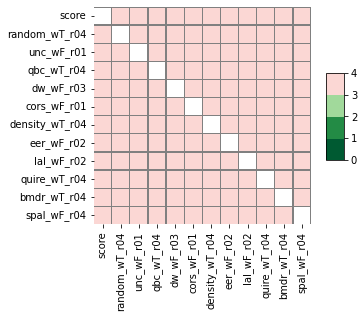

In [52]:
'''for k1 in nemenyi_results.keys():
  for k2 in nemenyi_results[k1].keys():
    pairwise_plotter(nemenyi_results[k1][k2])'''

#pairwise_plotter(nemenyi_results['overall']['total_internal_cpl'])
pairwise_plotter(conover_results['overall']['roc_auc'])

In [ ]:
sp.sign_plot(nemenyi_results['overall']['brier'])

## Run Friedman Tests for 2x60 models (average SCORES)

In [ ]:
"""
  Runs test comparing ALL models for each weight setup
"""


#model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
#metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1','total_internal_cost','total_internal_cpl','external_cost','external_cpl']
metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc','balanced_accuracy', 'f1', 'total_internal_cpl','external_cpl']  #'brier', 'h-measure', 'pcc',
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "pakdd", "australian", "german"] #,"thomas", 
#dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "hmeq", "australian", "german"]
#dataset_list = ["lendingclub", "thomas", "pakdd"]


friedman_results = {'wT':{}, 'wF':{}}
nemenyi_scores = {}
quade_scores = {}

for w in ['wT', 'wF']:
  friedman_results[w] = {}
  friedman_statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list)

  for s in metrics_list:
    metric_values = []

    for d in dataset_list:
      row_values = []
      columns = []

      for m in model_list:
        row_values.extend(performance.filter(regex=f'{m}_{w}').loc[performance.index.str.contains(f'{d}_{s}')].mean().tolist())
        columns.extend(list(performance.filter(regex=f'{m}_{w}').columns))
      
      metric_values.append(row_values)

    #invert sign of measurements for metrics where more is better – needed because friedmanchisquare() uses scipy.stats.rankdata(), which ranks in ascending fashion (low value -> low rank)
    if s not in ['brier','total_internal_cost','total_internal_cpl','external_cost','external_cpl']:
      metric_values = np.array(metric_values) * -1

    print('\n\n\n------------------------\nMETRIC', s)

    #statistic, pvalue,statistic_uncorr, p_uncorr,ranking,ranking_avg, rank_cmp = friedman_test(*np.transpose(metric_values))
    statistic, pvalue, ranking, ranking_avg, rank_cmp = friedmanchisquare2(*np.transpose(metric_values))

    print('\n-------------------------------\nscipy Friedman MODDED\n-------------------------------\n')
    for pr in [statistic, pvalue, ranking_avg, rank_cmp]: #, ranking,ranking_avg, rank_cmp]:
      print(pr)

    temp = {'statistic':statistic, 'pvalue':pvalue}
    friedman_statistics.loc[f'{s}'] = temp



    # POST HOC TEST HOLM
    ranks = {key: rank_cmp[i] for i, key in enumerate(columns)} 
    min_rank = pd.DataFrame(np.transpose(list(ranks.values())), index = ranks.keys()).iloc[:,0].argmin()
    
    comparisons, z_values, p_values, adj_p_values = holm_test(ranks, control=columns[min_rank])
    adj_p_values = np.asarray(adj_p_values)
    holm_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons)
    print(holm_scores)    


    comparisons, z_values, p_values, adj_p_values = finner_test(pivot_scores, control=columns[min_rank])
    adj_p_values = np.asarray(adj_p_values)
    finner_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons)
    print(finner_scores)
    #finner_results[w][s] = copy.deepcopy(finner_scores)


    #nemenyi_scores[s] = generate_scores(sp.posthoc_nemenyi_friedman, {}, metric_values, columns)
    #quade_scores[s] = generate_scores(sp.posthoc_quade, {}, metric_values, columns)


  print(np.shape(metric_values))
  print(f'Friedman results for {w}\n',friedman_statistics,'\n\n')
  friedman_results[w][r] = friedman_statistics

'''for key in nemenyi_scores.keys():
  pairwise_plotter(nemenyi_scores[key])'''





------------------------
METRIC roc_auc

-------------------------------
scipy Friedman MODDED
-------------------------------

275.40295307818246
1.1040457182485505e-29
[24.77777777777778, 24.77777777777778, 24.77777777777778, 24.77777777777778, 24.77777777777778, 51.111111111111114, 34.666666666666664, 25.88888888888889, 17.666666666666668, 21.444444444444443, 54.22222222222222, 38.0, 31.88888888888889, 28.77777777777778, 22.88888888888889, 55.111111111111114, 32.111111111111114, 21.555555555555557, 12.88888888888889, 16.0, 55.44444444444444, 42.0, 28.555555555555557, 25.555555555555557, 22.666666666666668, 47.888888888888886, 38.111111111111114, 24.555555555555557, 16.88888888888889, 17.444444444444443, 53.77777777777778, 35.22222222222222, 24.555555555555557, 16.77777777777778, 15.333333333333334, 54.22222222222222, 39.888888888888886, 29.666666666666668, 22.22222222222222, 21.77777777777778, 54.0, 38.111111111111114, 28.666666666666668, 23.88888888888889, 18.444444444444443, 47

ValueError: ignored

In [ ]:
columns = []
columns.append(performance.filter(regex='bmdr_wT').columns)
type(columns)

list

In [ ]:
 performance.filter(regex=f'{w}_{r}').columns

Index(['bmdr_wF_r05', 'cors_wF_r05', 'density_wF_r05', 'dw_wF_r05',
       'eer_wF_r05', 'lal_wF_r05', 'qbc_wF_r05', 'quire_wF_r05',
       'random_wF_r05', 'score_wF_r05', 'spal_wF_r05', 'unc_wF_r05'],
      dtype='object')

In [ ]:
pd.DataFrame(np.transpose(list(ranks.values())), index = ranks.keys())

,0
score_wF_r05,2.668498
random_wF_r05,3.780372
unc_wF_r05,3.520934
qbc_wF_r05,3.261497
dw_wF_r05,3.854496
cors_wF_r05,3.632122
density_wF_r05,3.039122
eer_wF_r05,3.150310
lal_wF_r05,4.521621
quire_wF_r05,2.446123


In [ ]:
ranks

{'bmdr_wF_r05': 2.816747403312185,
 'cors_wF_r05': 3.632121651639396,
 'density_wF_r05': 3.0391221983105146,
 'dw_wF_r05': 3.8544964466377265,
 'eer_wF_r05': 3.15030959580968,
 'lal_wF_r05': 4.521620831632717,
 'qbc_wF_r05': 3.261496993308845,
 'quire_wF_r05': 2.446122744981634,
 'random_wF_r05': 3.780371514971616,
 'score_wF_r05': 2.6684975399799646,
 'spal_wF_r05': 3.780371514971616,
 'unc_wF_r05': 3.5209342541402306}

In [ ]:
friedman_results

{'wF': {'r01':                     statistic    pvalue
  roc_auc             11.725275  0.384644
  brier               21.263736  0.030739
  h-measure            5.241758  0.918895
  pcc                  7.263736  0.777341
  balanced_accuracy   11.021978  0.441424
  f1                   9.461538   0.57937
  total_internal_cpl  40.538462  0.000029
  external_cpl        11.021978  0.441424,
  'r02':                     statistic    pvalue
  roc_auc              7.967033  0.716254
  brier               21.857143  0.025504
  h-measure            6.956044  0.802632
  pcc                  8.868132  0.634063
  balanced_accuracy    9.725275  0.555255
  f1                   5.285714  0.916544
  total_internal_cpl  43.175824   0.00001
  external_cpl         9.725275  0.555255,
  'r03':                     statistic    pvalue
  roc_auc              6.802198  0.814868
  brier               19.769231  0.048608
  h-measure            4.296703   0.96042
  pcc                  9.527473  0.573323
  bal

## run separate tests for each combination of weights and ratio

In [ ]:
#Friedman Test with post-hoc test
#model_list = ['score', 'random', 'unc', 'qbc', 'dw', 'cors', 'density', 'eer', 'lal', 'quire', 'bmdr', 'spal']
#metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc', 'balanced_accuracy', 'f1','total_internal_cost','total_internal_cpl','external_cost','external_cpl']
metrics_list = ['roc_auc', 'brier', 'h-measure', 'pcc','balanced_accuracy', 'f1', 'total_internal_cpl','external_cpl']  #'brier', 'h-measure', 'pcc',
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "pakdd"] #"australian", "german", "thomas", 
#dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "hmeq", "australian", "german"]
#dataset_list = ["lendingclub", "thomas", "pakdd"]


friedman_results = {'wT':{}, 'wF':{}}
nemenyi_scores = {}
quade_scores = {}

average_ratios = False #this feature does not work correctly, if this is enabled it is unnecessary to loop over ratios. 

for w in ['wT', 'wF']:
  friedman_results[w] = {}
  
  for r in ["r01","r02","r03","r04","r05"]:
    friedman_statistics = pd.DataFrame(columns=['statistic', 'pvalue'], index=metrics_list)

    for s in metrics_list:
      metric_values = []

      for d in dataset_list:
        row_values = []
        if average_ratios:
          columns = model_list
        else:
          columns = []

        for m in model_list:
          if average_ratios:
            row_values.append(performance.filter(regex=f'{m}_{w}').loc[performance.index.str.contains(f'{d}_{s}')].mean().mean())
          else:
            row_values.extend(performance.filter(regex=f'{m}_{w}_{r}').loc[performance.index.str.contains(f'{d}_{s}')].mean().tolist())
            columns.append(f'{m}_{w}_{r}')
        
        metric_values.append(row_values)

      #invert sign of measurements for metrics where more is better – needed because friedmanchisquare() uses scipy.stats.rankdata(), which ranks in ascending fashion (low value -> low rank)
      if s not in ['brier','total_internal_cost','total_internal_cpl','external_cost','external_cpl']:
        metric_values = np.array(metric_values) * -1

      print('\n\n\n------------------------\nMETRIC', s)

      #statistic, pvalue,statistic_uncorr, p_uncorr,ranking,ranking_avg, rank_cmp = friedman_test(*np.transpose(metric_values))
      statistic, pvalue, ranking, ranking_avg, rank_cmp = friedmanchisquare2(*np.transpose(metric_values))

      print('\n-------------------------------\nscipy Friedman MODDED\n-------------------------------\n')
      for pr in [statistic, pvalue, ranking_avg, rank_cmp]: #, ranking,ranking_avg, rank_cmp]:
        print(pr)

      print('\n-------------------------------\nCustom STAC\n-------------------------------\n')
      print(friedman_test(*np.transpose(metric_values)))

      temp = {'statistic':statistic, 'pvalue':pvalue}
      friedman_statistics.loc[f'{s}'] = temp



      # POST HOC TEST HOLM
      ranks = {key: rank_cmp[i] for i, key in enumerate(columns)} 
      print('ranking_avg', ranking_avg)
      print(pd.DataFrame(np.transpose(list(ranks.values())), index = ranks.keys()).iloc[:,0])
      min_rank = pd.DataFrame(np.transpose(list(ranks.values())), index = ranks.keys()).iloc[:,0].argmin()
      
      comparisons, z_values, p_values, adj_p_values = holm_test(ranks, control=columns[min_rank])
      adj_p_values = np.asarray(adj_p_values)
      holm_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < 0.05}, index=comparisons)
      print(holm_scores)    

      #nemenyi_scores[s] = generate_scores(sp.posthoc_nemenyi_friedman, {}, metric_values, columns)
      #quade_scores[s] = generate_scores(sp.posthoc_quade, {}, metric_values, columns)


    print(np.shape(metric_values))
    print(f'Friedman results for {w}\n',friedman_statistics,'\n\n')
    friedman_results[w][r] = friedman_statistics

'''for key in nemenyi_scores.keys():
  pairwise_plotter(nemenyi_scores[key])'''





------------------------
METRIC roc_auc

-------------------------------
scipy Friedman MODDED
-------------------------------

25.571428571428612
0.0075125990565410835
[1.4285714285714286, 5.857142857142857, 8.0, 7.714285714285714, 8.0, 6.428571428571429, 6.142857142857143, 9.285714285714286, 7.428571428571429, 4.428571428571429, 7.714285714285714, 5.571428571428571]
[0.7412493166611012, 3.0391221983105146, 4.1509961733021665, 4.002746309969947, 4.1509961733021665, 3.3356219249749555, 3.1873720616427352, 4.818120558297158, 3.8544964466377265, 2.297872881649414, 4.002746309969947, 2.8908723349782943]

-------------------------------
Custom STAC
-------------------------------

(2.9833333333333334, 0.002844721456970456, 25.571428571428573, 0.0075125990565411945, [[1.0, 6.0, 12.0, 10.0, 3.0, 2.0, 7.0, 11.0, 9.0, 5.0, 8.0, 4.0], [3.0, 8.0, 7.0, 9.0, 11.0, 1.0, 5.0, 2.0, 4.0, 10.0, 6.0, 12.0], [1.0, 7.0, 10.0, 6.0, 11.0, 8.0, 2.0, 9.0, 12.0, 3.0, 5.0, 4.0], [1.0, 2.0, 10.0, 4.0, 9.0, 7.

'for key in nemenyi_scores.keys():\n  pairwise_plotter(nemenyi_scores[key])'